In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
import seaborn as sns
import keras
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
#from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

# Convert Video to Audio

In [4]:
# Path to the folder containing your MP4 files
video_folder = r'C:\Users\sandesh\Desktop\audio_analysis\CUSTOM_DATA\CUSTOM_VIDEO'

# Path for the converted (WAV) files
output_folder = r'C:\Users\sandesh\Desktop\audio_analysis\CUSTOM_DATA'

# List all MP4 files in the input folder
video_files = [file for file in os.listdir(video_folder) if file.endswith('.mp4')]

In [5]:
# Function to convert the mp4 to wav
def convert_to_wav(input_mp4_file, output_wav_file):
    # Load the video clip
    video_clip = VideoFileClip(input_mp4_file)

    # Extract the audio
    audio_clip = video_clip.audio

    # Save the audio as a WAV file
    audio_clip.write_audiofile(output_wav_file)

In [6]:
# Convert each MP4 file to WAV and save the file names in the text file
def init_conversion():
    for video_file in video_files:
        mp4_path = os.path.join(video_folder, video_file)
        wav_path = os.path.join(output_folder, video_file.replace('.mp4', '.wav'))

        if not os.path.exists(wav_path):
            # Convert MP4 to WAV
            convert_to_wav(mp4_path, wav_path)
        else:
            print(f"WAV file for {mp4_file} already exists. Skipping conversion.")

    print("Conversion completed.")

In [7]:
# Uncomment the below function call if conversion mp4 to wav conversion is needed
#init_conversion()

MoviePy - Writing audio in C:\Users\sandesh\Desktop\audio_analysis\CUSTOM_DATA\angry_custom_01.wav


MoviePy - Done.
MoviePy - Writing audio in C:\Users\sandesh\Desktop\audio_analysis\CUSTOM_DATA\calm_custom_01.wav


MoviePy - Done.


MoviePy - Writing audio in C:\Users\sandesh\Desktop\audio_analysis\CUSTOM_DATA\calm_custom_02.wav


MoviePy - Done.
MoviePy - Writing audio in C:\Users\sandesh\Desktop\audio_analysis\CUSTOM_DATA\sad_custom_01.wav


MoviePy - Done.
MoviePy - Writing audio in C:\Users\sandesh\Desktop\audio_analysis\CUSTOM_DATA\sad_custom_02.wav


MoviePy - Done.
MoviePy - Writing audio in C:\Users\sandesh\Desktop\audio_analysis\CUSTOM_DATA\suprise_custom_01.wav


MoviePy - Done.
Conversion completed.


# Feature Extraction Using LIBROSA

In [8]:
# Function to extract audio features
def extract_features(audio_file_path):
    # Load audio file
    y, sample_rate = librosa.load(audio_file_path, duration=3)

    # Extract features
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=13), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sample_rate), axis=1)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sample_rate), axis=1)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sample_rate), axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sample_rate), axis=1)

    return np.concatenate([mfccs, chroma, mel, contrast, tonnetz])

### CUSTOM DATA

In [9]:
# Path to the CUSTOM dataset
custom_path = r"C:\Users\sandesh\Desktop\audio_analysis\CUSTOM_DATA"

In [13]:
# Function to extract features from CUSTOM dataset
def init_feature_extract_custom():
    # Initializing lists to store features and labels
    features = []
    labels = []

    # Iterate through each audio file in the dataset path
    for root, dirs, files in os.walk(ravdess_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                emotion = file.split("_")[0]  # Extract emotion from filename

                # Extract features
                audio_features = extract_features(file_path)

                # Append features and labels
                features.append(audio_features)
                labels.append(emotion)

    # Create a DataFrame
    columns = [f"feature_{i}" for i in range(len(features[0]))]
    df_custom = pd.DataFrame(features, columns=columns)
    df_custom['emotion'] = labels

    # Save the DataFrame to a CSV file
    df_custom.to_csv(r"C:\Users\sandesh\Desktop\audio_analysis\audio_features_CUSTOM.csv", index=False)

In [54]:
# Uncomment the below function call to intialize the CUSTOM Dataset feature extraction
#init_feature_extract_custom()

### RAVDESS

In [3]:
# Path to the RAVDESS dataset
ravdess_path = r"audio_analysis\RAVDESS"

In [ ]:
# Function to extract features from RAVDESS dataset
def init_feature_extract_ravdess():
    # Initializing lists to store features and labels
    features = []
    labels = []

    # Iterate through each audio file in the dataset path
    for root, dirs, files in os.walk(ravdess_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                emotion = file.split("-")[2]  # Extract emotion from filename

                # Extract features
                audio_features = extract_features(file_path)

                # Append features and labels
                features.append(audio_features)
                labels.append(emotion)

    # Create a DataFrame
    columns = [f"feature_{i}" for i in range(len(features[0]))]
    df_ravdess = pd.DataFrame(features, columns=columns)
    df_ravdess['emotion'] = labels

    df_ravdess.emotion.replace({'01':'neutral', '02':'calm', '03':'happy', '04':'sad', '05':'angry', '06':'fear', '07':'disgust',
                                 '08':'surprise'},
                                inplace=True)
    # Save the DataFrame to a CSV file
    df_ravdess.to_csv(r"audio_analysis\audio_features_RAVDESS.csv", index=False)

In [75]:
# Uncomment the below function call to intialize the RAVDESS Dataset feature extraction
#init_feature_extract_ravdess()

### CREMA-D

In [ ]:
# Path to CREMA-D dataset path
crema_path = r'audio_analysis\CREMA-D\AudioWAV'

In [34]:
# Function to extract features from CREMA-D dataset
def init_feature_extract_crema():
    
    features = []
    labels = []

    # Emotion labels in CREMA-D
    emotion_labels = {
        'ANG': 'angry', # Angry
        'DIS': 'disgust', # Disgust
        'FEA': 'fear', # Fear
        'HAP': 'happy', # Happy
        'NEU': 'neutral', # Neutral
        'SAD': 'sad', # Sad
    }

    for root, dirs, files in os.walk(crema_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                parts = file.split('_')  # Extract emotion from filename
                emotion = parts[2]

                # Extract features
                audio_features = extract_features(file_path)

                # Append features and labels
                features.append(audio_features)
                if emotion in emotion_labels:
                    labels.append(emotion_labels[emotion])


    columns = [f"feature_{i}" for i in range(len(features[0]))]
    df_crema = pd.DataFrame(features, columns=columns)
    df_crema['emotion'] = labels
    
    # Save the DataFrame to a CSV file
    df_crema.to_csv(r"audio_analysis\audio_features_CREMA.csv", index=False)


In [36]:
# Uncomment the below function call to intialize the CREMA-D Dataset feature extraction
#init_feature_extract_crema()

### SAVEE

In [ ]:
# Path to SAVEE dataset
savee_path = r'audio_analysis\SAVEE'

In [50]:
# Function to extract the features from SAVEE dataset
def init_feature_extract_savee():
    features = []
    labels = []

    # Emotion labels in SAVEE
    emotion_labels = {
        'a': 'angry',
        'd': 'disgust',
        'f': 'fear',
        'h': 'happy',
        'n': 'neutral',
        'sa': 'sad',
        'su': 'surprise'
    }

    for root, dirs, files in os.walk(savee_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                parts = file.split('_')  # Extract emotion from filename
                emotion = parts[1].split('.')[0][:-2]

                # Extract features
                audio_features = extract_features(file_path)

                # Append features and labels
                features.append(audio_features)
                if emotion in emotion_labels:
                    labels.append(emotion_labels[emotion])


    columns = [f"feature_{i}" for i in range(len(features[0]))]
    df_savee = pd.DataFrame(features, columns=columns)
    df_savee['emotion'] = labels
    
    # Save the DataFrame to a CSV file
    df_savee.to_csv(r"audio_analysis\audio_features_SAVEE.csv", index=False)


In [51]:
# Uncomment the below function call to intialize the SAVEE Dataset feature extraction
#init_feature_extract_savee()

### TESS

In [ ]:
# Path to the TESS dataset
tess_path = r'audio_analysis\TESS'

In [32]:
# Function to extract the features from TESS dataset
def init_feature_extract_tess():
    features = []
    labels = []

    # Emotion labels in TESS
    emotion_map = {
        'angry': 'angry',
        'disgust': 'disgust',
        'fear': 'fear',
        'happy': 'happy',
        'sad': 'sad',
        'neutral': 'neutral',
        'ps': 'surprise'
    }

    for root, dirs, files in os.walk(tess_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                parts = file.split('_')  # Extract emotion from filename
                emotion = parts[2].split('.')[0]

                # Extract features
                audio_features = extract_features(file_path)

                # Append features and labels
                features.append(audio_features)
                if emotion in emotion_map:
                    labels.append(emotion_map[emotion])

    columns = [f"feature_{i}" for i in range(len(features[0]))]
    df_tess = pd.DataFrame(features, columns=columns)
    df_tess['emotion'] = labels
    
    # Save the DataFrame to a CSV file
    df_tess.to_csv(r"audio_analysis\audio_features_TESS.csv", index=False)

In [37]:
# Uncomment the below function call to intialize the TESS Dataset feature extraction
#init_feature_extract_tess()

# Data Exploration

In [ ]:
df_ravdess = pd.read_csv(r'audio_analysis\audio_features_RAVDESS.csv')
df_savee = pd.read_csv(r'audio_analysis\audio_features_SAVEE.csv')
df_tess = pd.read_csv(r'audio_analysis\audio_features_TESS.csv')
df_crema = pd.read_csv(r'audio_analysis\audio_features_CREMA.csv')

In [52]:
df_ravdess.head()

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0 -682.972595  60.794384   0.667986  13.581243   8.255360   0.469162   
1 -618.224976  60.720490 -14.918141   7.509526  -7.221067  -6.115078   
2 -591.774170  61.883774  -5.655419  10.206791   3.372344  -3.807934   
3 -678.768860  45.411369  -9.623674   9.292001  -5.039160  -5.443626   
4 -683.316345  80.128052   7.614270  16.220486  12.356831  -0.859792   

   feature_6  feature_7  feature_8  feature_9  ...  feature_157  feature_158  \
0  -3.830322  -3.496364 -12.246050  -3.188734  ...    15.582570    17.464205   
1  -7.779987 -11.299585  -5.332608  -1.319931  ...    18.080161    18.220640   
2 -14.487039  -8.192768  -3.921117 -10.055596  ...    17.776296    17.148391   
3  -7.097850 -13.581819  -7.753093  -3.535996  ...    17.574908    17.756150   
4  -0.089908  -4.387408  -1.554500   0.847795  ...    16.739225    16.606387   

   feature_159  feature_160  feature_161  feature_162  feature_163  \
0    37.482555    -0.017602    -0.009138    -0.042508    -0.033097   
1    39.485018    -0.042684     0.043122     0.011886    -0.022725   
2    37.067399    -0.017336     0.004137     0.000195     0.030213   
3    37.239142    -0.019968     0.007001    -0.065509     0.010731   
4    45.813961    -0.025414     0.045839    -0.076385    -0.014015   

   feature_164  feature_165  emotion  
0    -0.008986     0.011591       01  
1    -0.002582    -0.001319       01  
2    -0.002334    -0.009004       01  
3    -0.008258     0.001199       01  
4     0.012877     0.008864       01  

[5 rows x 167 columns]

In [56]:
df_ravdess.shape

(2760, 167)

In [53]:
df_savee.head()

feature_0   feature_1  feature_2  feature_3  feature_4  feature_5  \
0 -294.017426  123.375153  11.715846  38.348587  10.842897  -5.621662   
1 -271.385040  135.111633 -12.951858  17.770845  13.349401  -5.160909   
2 -334.136841   99.700531   4.931632  26.754679  10.594255  -2.287611   
3 -286.489502  102.832703   7.022041  15.775354   7.510128  -1.510050   
4 -296.592560   94.003502   0.574513  22.929649  13.077610  -2.062614   

   feature_6  feature_7  feature_8  feature_9  ...  feature_157  feature_158  \
0 -29.214239  -4.132798  -2.527533 -15.080048  ...    21.635877    18.075197   
1 -25.298679   2.716135   3.958584 -14.392535  ...    20.732989    19.525470   
2 -14.036965   7.078952  -0.150705  -7.470180  ...    17.095134    16.784724   
3 -24.844368  -5.162172  -0.033200 -10.830236  ...    20.398517    17.712607   
4 -23.076244  -2.964437  -2.903373 -14.101274  ...    21.777211    19.393228   

   feature_159  feature_160  feature_161  feature_162  feature_163  \
0    50.553800    -0.020011    -0.025850    -0.068642     0.013268   
1    50.613039     0.010049     0.013287    -0.067259    -0.005431   
2    48.543257     0.021843     0.032126     0.058734    -0.010689   
3    51.176567     0.024675     0.012357    -0.026792     0.059341   
4    50.005244    -0.004873     0.010725    -0.031096     0.038666   

   feature_164  feature_165  emotion  
0    -0.013760    -0.002476    angry  
1    -0.010020     0.004013    angry  
2     0.019811    -0.007034    angry  
3    -0.010187    -0.028614    angry  
4    -0.019987    -0.017177    angry  

[5 rows x 167 columns]

In [57]:
df_savee.shape

(480, 167)

In [54]:
df_tess.head()

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0 -383.432617  52.460812 -17.608944 -11.810310  -4.707629   7.513891   
1 -483.182831  90.582314   9.383311  -4.021622  12.589835   4.044669   
2 -434.416840  61.591843   1.869823  -8.288074   2.913273   3.220164   
3 -466.621094  84.984451  10.384984 -11.918968   3.862795   7.883589   
4 -527.842163  86.384857  13.286591   1.929372  14.471400  10.854506   

   feature_6  feature_7  feature_8  feature_9  ...  feature_157  feature_158  \
0 -25.082636  -6.948460 -10.093306  -3.254937  ...    23.315031    19.226012   
1  -5.524430  -0.138239 -14.309569   2.843628  ...    18.607748    17.665929   
2 -13.606012  -0.346507 -10.710852   3.896621  ...    21.470767    18.120763   
3 -13.602763   2.811264  -8.939720  -0.834624  ...    19.649940    18.200657   
4  -6.964576  -5.168907 -10.792578   4.990290  ...    22.471326    18.038570   

   feature_159  feature_160  feature_161  feature_162  feature_163  \
0    47.541857    -0.003866     0.042722     0.075534     0.149688   
1    47.677173     0.030976    -0.009442     0.042879     0.083759   
2    47.550400     0.024068     0.028317    -0.098504    -0.104481   
3    47.585560    -0.043458     0.019386    -0.098393     0.025271   
4    46.998316    -0.056616    -0.156116    -0.196674    -0.257338   

   feature_164  feature_165  emotion  
0     0.015605     0.039874    angry  
1     0.032501    -0.003283  disgust  
2    -0.022394    -0.018994     fear  
3    -0.010613     0.025784    happy  
4    -0.003513     0.075326  neutral  

[5 rows x 167 columns]

In [58]:
df_tess.shape

(2800, 167)

In [55]:
df_crema.head()

feature_0   feature_1  feature_2  feature_3  feature_4  feature_5  \
0 -341.988922  120.799965  -9.834449  39.606232  -2.239531  13.864773   
1 -388.461945  133.882111 -17.753077  53.109615  -0.516854  22.838816   
2 -352.208435  115.791069  -3.415168  32.881832   5.439893  11.282280   
3 -337.839569  120.109604 -12.691746  39.687584   4.412654  10.073729   
4 -368.175568  124.364937  -4.643919  39.390568   6.951158  12.446601   

   feature_6  feature_7  feature_8  feature_9  ...  feature_157  feature_158  \
0 -18.852041  -2.982337 -11.125524  -2.109577  ...    19.071770    18.205979   
1 -23.992502   7.696455 -11.807550  -1.607505  ...    18.085921    17.060619   
2 -16.918011  -0.038774  -7.281857  -3.811908  ...    18.730261    17.162776   
3 -21.633322   0.222240 -10.304430  -6.165375  ...    19.129519    17.681320   
4 -13.139218  -2.361498 -10.503442  -4.843660  ...    18.459605    18.373701   

   feature_159  feature_160  feature_161  feature_162  feature_163  \
0    64.869336    -0.003190     0.008633    -0.001825    -0.101469   
1    64.169785    -0.009454    -0.030336    -0.055102    -0.040881   
2    60.655992    -0.007597     0.053141    -0.030707    -0.034196   
3    62.066600     0.017944     0.044452    -0.065497    -0.030693   
4    63.250329     0.016330     0.010619    -0.010604    -0.074785   

   feature_164  feature_165  emotion  
0     0.005897    -0.000400    angry  
1     0.013961     0.006287  disgust  
2     0.025275     0.009450     fear  
3    -0.012118     0.009784    happy  
4     0.017251    -0.006720  neutral  

[5 rows x 167 columns]

In [59]:
df_crema.shape

(7442, 167)

In [76]:
df_concatenated = pd.concat([df_ravdess, df_savee, df_tess,df_crema], axis=0, ignore_index=True)

# Save the DataFrame to a CSV file
df_concatenated.to_csv(r"audio_analysis\audio_features_ALL.csv", index=False)

In [77]:
new_df = pd.read_csv(r'audio_analysis\audio_features_ALL.csv')
new_df.head()

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0 -682.972595  60.794384   0.667986  13.581243   8.255360   0.469162   
1 -618.224976  60.720490 -14.918141   7.509526  -7.221067  -6.115078   
2 -591.774170  61.883774  -5.655419  10.206791   3.372344  -3.807934   
3 -678.768860  45.411369  -9.623674   9.292001  -5.039160  -5.443626   
4 -683.316345  80.128052   7.614270  16.220486  12.356831  -0.859792   

   feature_6  feature_7  feature_8  feature_9  ...  feature_157  feature_158  \
0  -3.830322  -3.496364 -12.246050  -3.188734  ...    15.582570    17.464205   
1  -7.779987 -11.299585  -5.332608  -1.319931  ...    18.080161    18.220640   
2 -14.487039  -8.192768  -3.921117 -10.055596  ...    17.776296    17.148391   
3  -7.097850 -13.581819  -7.753093  -3.535996  ...    17.574908    17.756150   
4  -0.089908  -4.387408  -1.554500   0.847795  ...    16.739225    16.606387   

   feature_159  feature_160  feature_161  feature_162  feature_163  \
0    37.482555    -0.017602    -0.009138    -0.042508    -0.033097   
1    39.485018    -0.042684     0.043122     0.011886    -0.022725   
2    37.067399    -0.017336     0.004137     0.000195     0.030213   
3    37.239142    -0.019968     0.007001    -0.065509     0.010731   
4    45.813961    -0.025414     0.045839    -0.076385    -0.014015   

   feature_164  feature_165  emotion  
0    -0.008986     0.011591  neutral  
1    -0.002582    -0.001319  neutral  
2    -0.002334    -0.009004  neutral  
3    -0.008258     0.001199  neutral  
4     0.012877     0.008864  neutral  

[5 rows x 167 columns]

In [78]:
new_df.shape

(13482, 167)

In [82]:
new_df.describe()

feature_0     feature_1     feature_2     feature_3     feature_4  \
count  13482.000000  13482.000000  13482.000000  13482.000000  13482.000000   
mean    -484.475232     94.265564      4.908305     31.589008     -7.061663   
std      233.434903     49.046473     13.394191     24.238820      9.971169   
min    -1131.370972    -13.381644    -63.916203    -36.367371    -44.100845   
25%     -465.534424     56.116776     -2.380381      7.688358    -14.205570   
50%     -414.409531    112.812183      4.939502     37.235785     -7.687271   
75%     -366.473312    136.289589     14.400045     52.173622      0.000000   
max     -162.543350    177.204987     47.074280     83.296509     32.897644   

          feature_5     feature_6     feature_7     feature_8     feature_9  \
count  13482.000000  13482.000000  13482.000000  13482.000000  13482.000000   
mean      10.588942    -11.261288      1.513721     -9.800074      0.621923   
std       14.499236      7.818378     10.024574      5.912354      4.742787   
min      -33.215916    -40.119652    -32.080994    -33.062550    -24.419167   
25%        0.000000    -16.977329     -4.390692    -13.853749     -1.706162   
50%        8.590457    -11.840173      1.988738    -10.587705      0.636556   
75%       22.224154     -5.308560      9.008149     -6.404685      3.894224   
max       61.742851     13.893981     30.958349     11.274472     27.307823   

       ...   feature_156   feature_157   feature_158   feature_159  \
count  ...  13482.000000  13482.000000  13482.000000  13482.000000   
mean   ...     15.464513     16.196064     16.107339     52.296399   
std    ...      5.617443      5.825260      5.797695     19.823411   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...     15.252173     16.134314     15.955050     47.236592   
50%    ...     16.435900     17.253078     17.259061     63.200754   
75%    ...     18.114521     18.965666     18.922004     65.750508   
max    ...     27.456207     27.974221     28.401111     72.041066   

        feature_160   feature_161   feature_162   feature_163   feature_164  \
count  13482.000000  13482.000000  13482.000000  13482.000000  13482.000000   
mean      -0.001939      0.000337     -0.042037     -0.028660      0.011008   
std        0.035595      0.039582      0.073698      0.068717      0.021978   
min       -0.227146     -0.419199     -0.364973     -0.438285     -0.131003   
25%       -0.019663     -0.015178     -0.085605     -0.060827      0.000000   
50%        0.000000      0.000000     -0.044651     -0.022959      0.011246   
75%        0.014703      0.017009      0.000000      0.001574      0.023484   
max        0.246403      0.286655      0.435881      0.336717      0.136340   

        feature_165  
count  13482.000000  
mean       0.004585  
std        0.021962  
min       -0.124574  
25%       -0.005562  
50%        0.001978  
75%        0.014859  
max        0.152037  

[8 rows x 166 columns]

In [172]:
new_df.isna().sum()

feature_0      0
feature_1      0
feature_2      0
feature_3      0
feature_4      0
              ..
feature_162    0
feature_163    0
feature_164    0
feature_165    0
emotion        0
Length: 167, dtype: int64

##### Emotion Distribution in Dataset

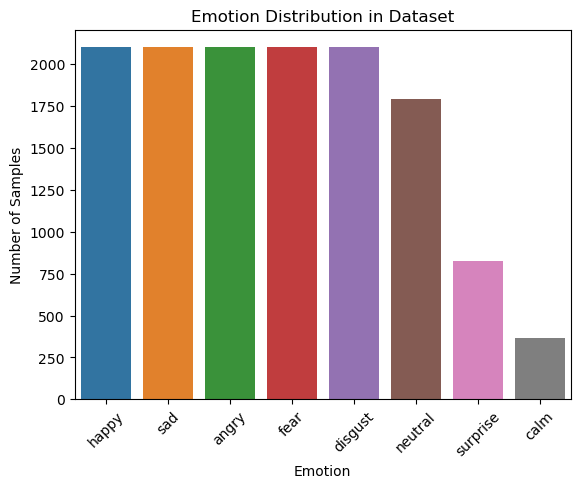

In [113]:
# To plot the distribution of emotion in dataset 
emotion_count = new_df['emotion'].value_counts()
sns.barplot(x=emotion_count.index, y=emotion_counts.values)
plt.title('Emotion Distribution in Dataset')
plt.ylabel('Number of Audio Samples')
plt.xlabel('Emotion')
plt.xticks(rotation=45)
plt.show()


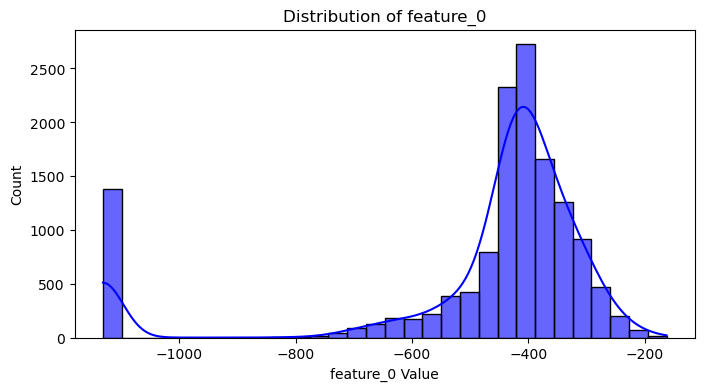

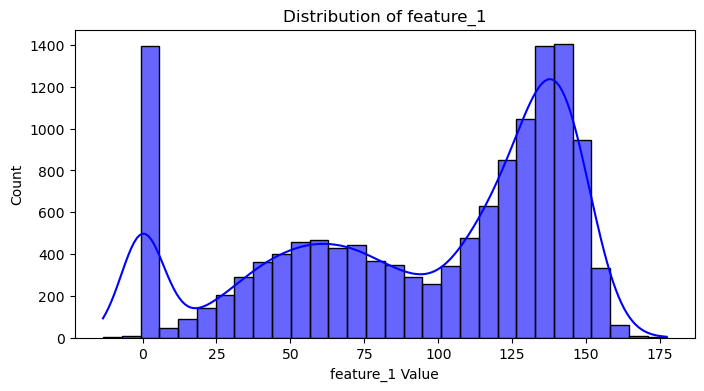

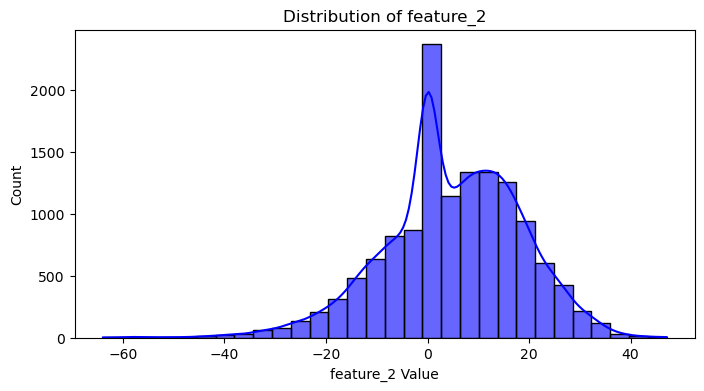

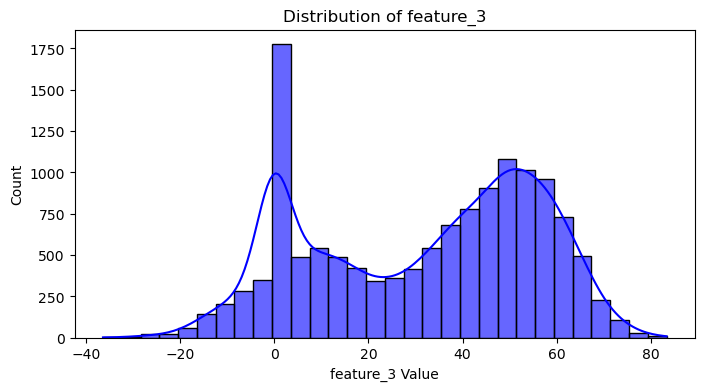

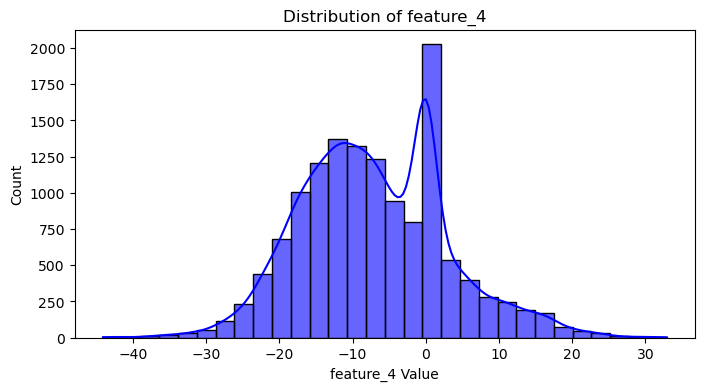

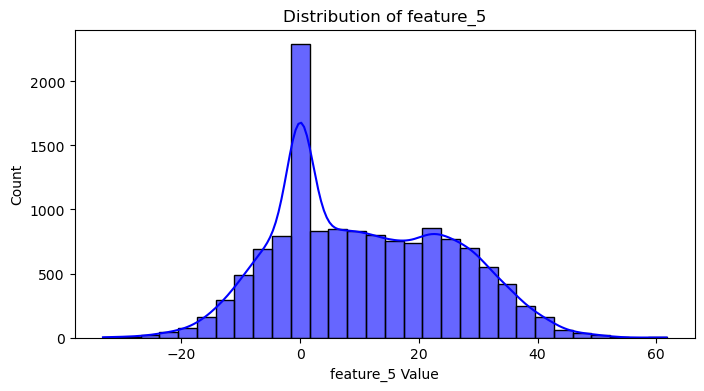

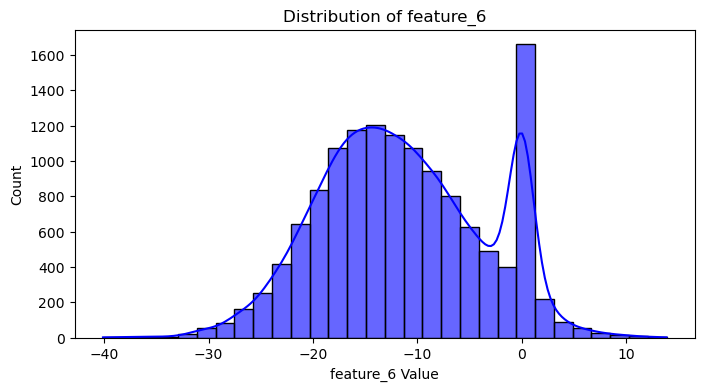

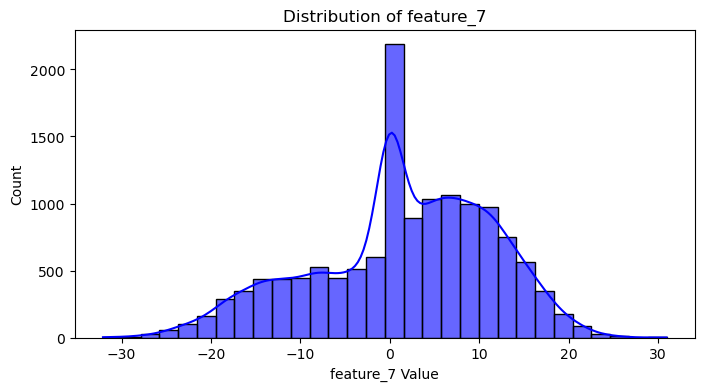

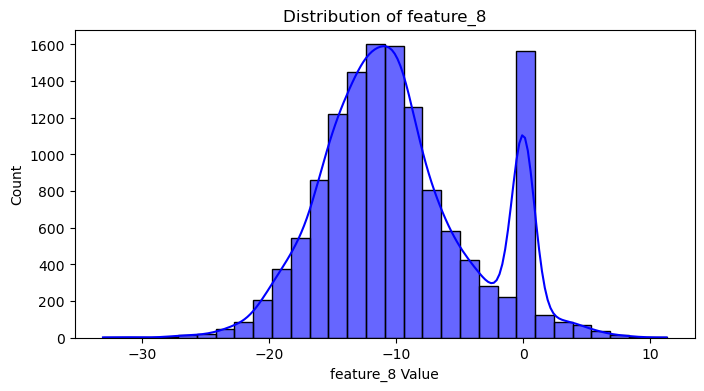

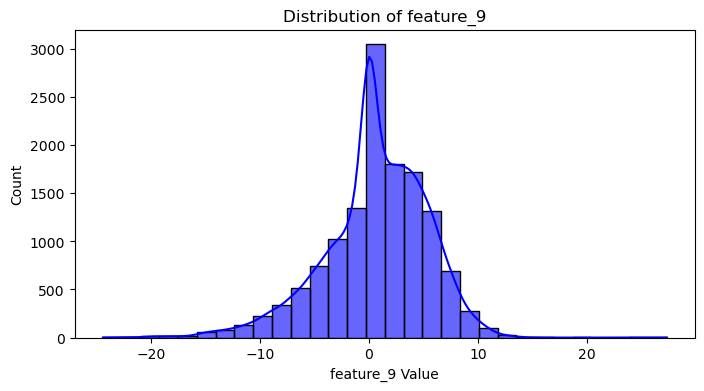

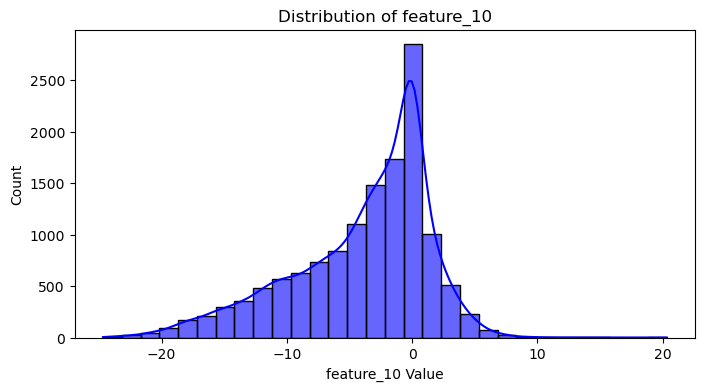

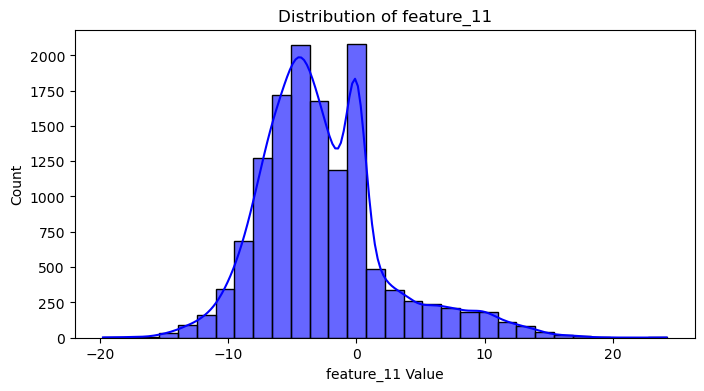

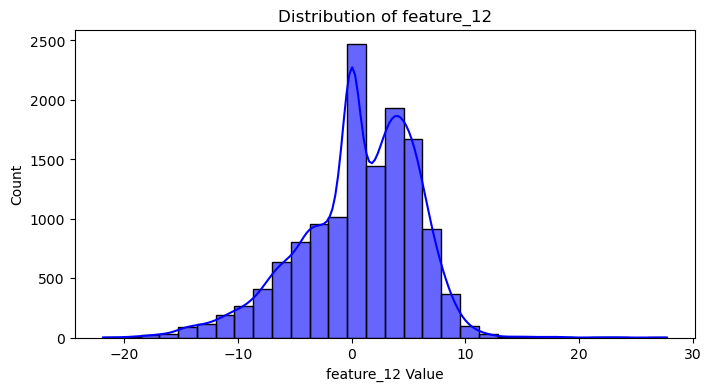

In [176]:
# MFCC feature distribution (first 13 feature will be related to MFCC)
for i in range(13):
    plt.figure(figsize=(8, 4))
    sns.histplot(new_df[f'feature_{i}'], kde=True, bins=30, alpha=0.6, color='blue')
    plt.title(f'Distribution of feature_{i}')
    plt.xlabel(f'feature_{i} Value')
    plt.ylabel('Count')
    plt.show()

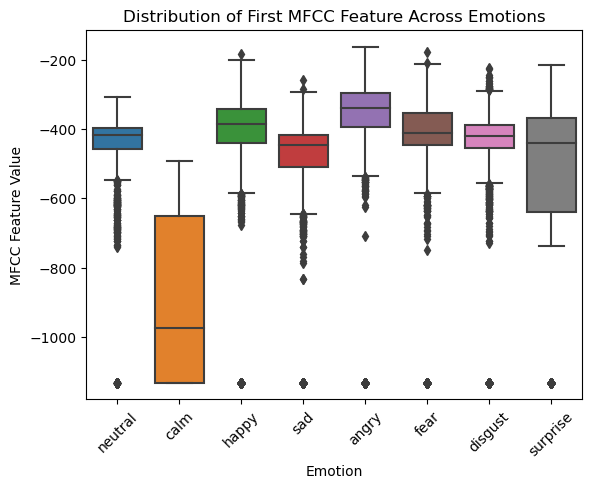

In [115]:
# To plot the distribution of first MFCC feature across different emotions
sns.boxplot(x='emotion', y=new_df.columns[0], data=new_df) 
plt.title('Distribution of First MFCC Feature Across Emotions')
plt.xlabel('Emotion')
plt.ylabel('MFCC Feature Value')
plt.xticks(rotation=45)
plt.show()


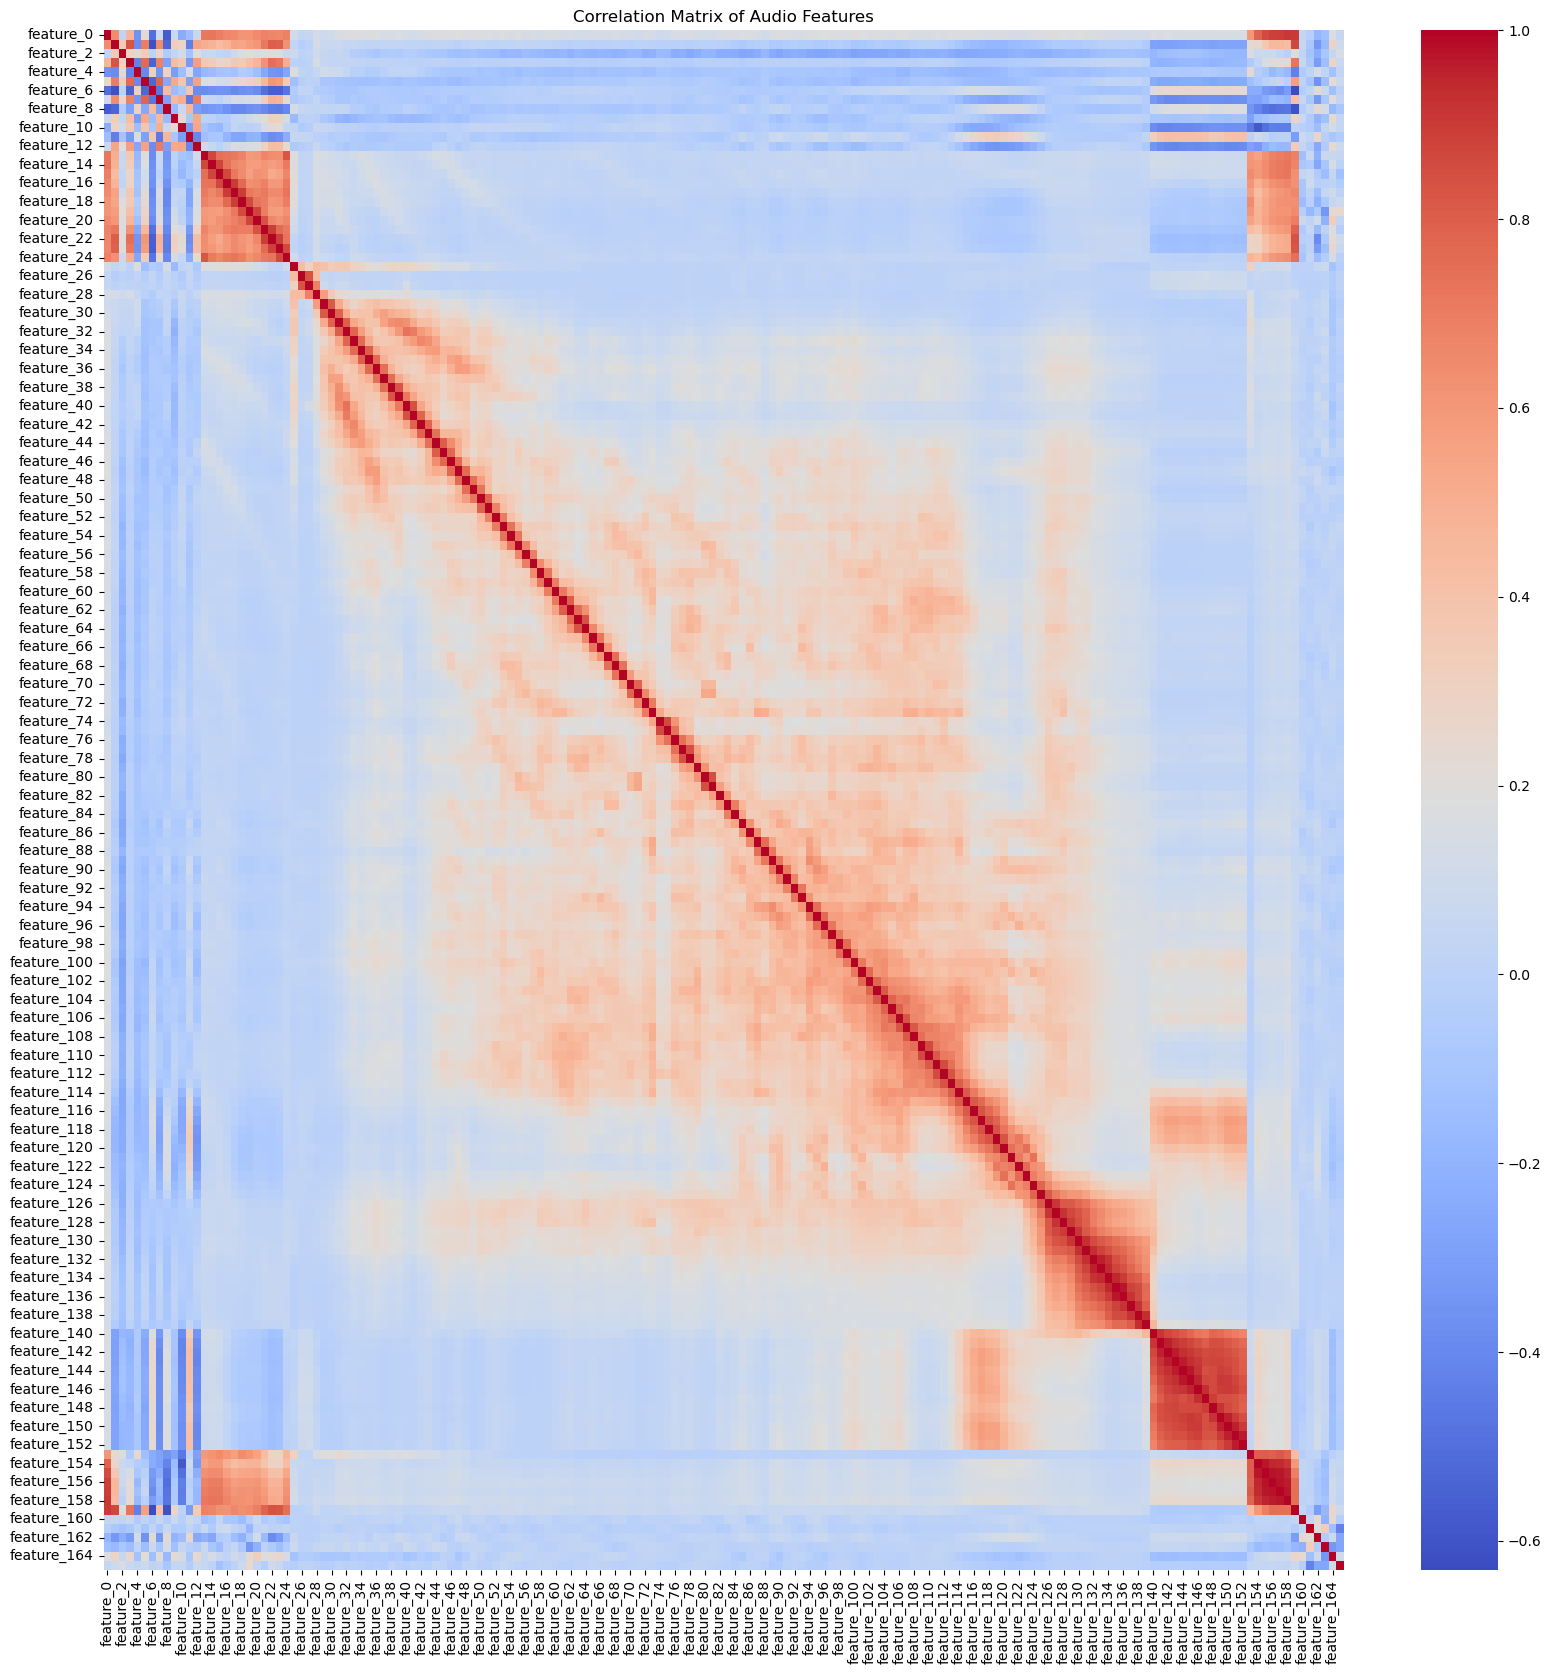

In [184]:
# In dataset all columns except 'emotion' are extracted features
feature_columns = new_df.columns[:-1]  # this will exclude the emotion column
correlation_matrix = new_df[feature_columns].corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Extracted Audio Features')
plt.show()


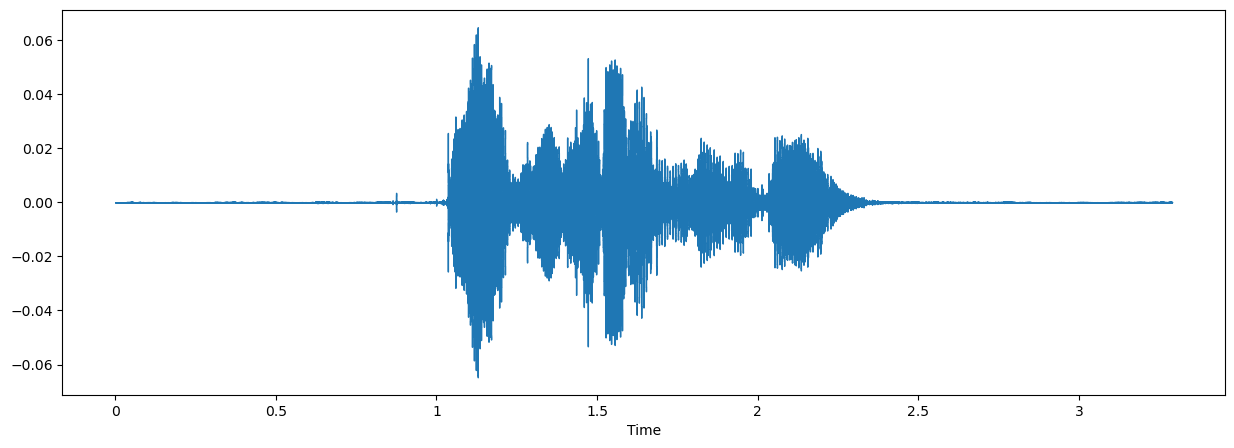

In [191]:
audio_path = r'RAVDESS\01-01-03-01-02-02-11.wav'
audio, sr = librosa.load(audio_path)
mfccs = librosa.feature.mfcc(y=audio, sr=sr)

plt.figure(figsize=(15, 5))
librosa.display.waveshow(audio, sr=sr)

# Lets play the audio 
ipd.Audio(audio_path)


216
216


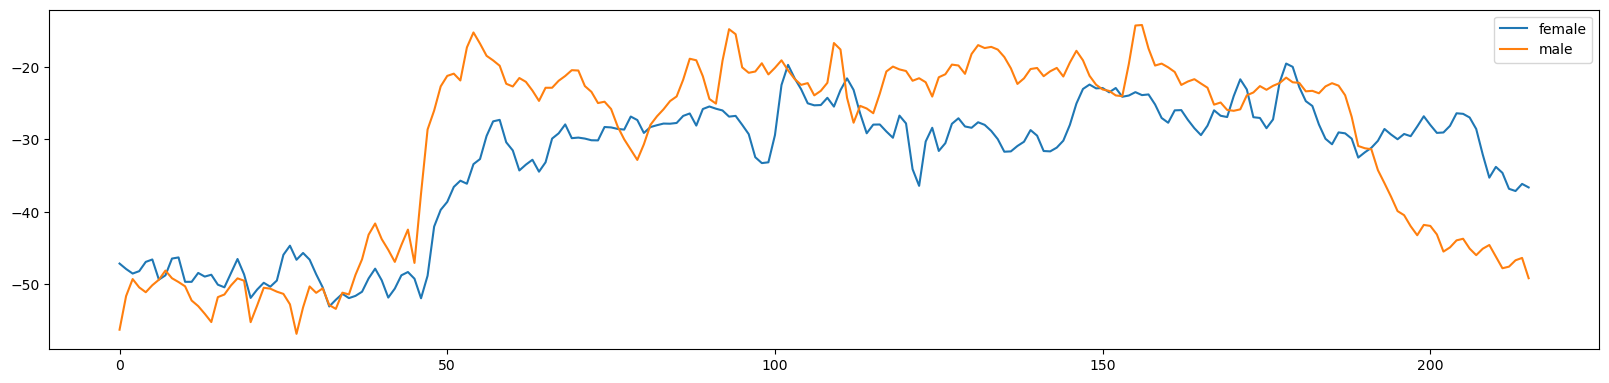

In [149]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
aud_path = r"RAVDESS\01-01-05-01-01-01-10.wav"
data, sample_rate = librosa.load(aud_path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female_mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)
female_mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female_mfcc))

# Source - RAVDESS; Gender - Male; Emotion - Angry 
aud_path_2 = r"RAVDESS\01-01-05-01-01-01-11.wav"
data, sample_rate = librosa.load(aud_path_2, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male_mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)
male_mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male_mfcc))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female_mfcc, label='female')
plt.plot(male_mfcc, label='male')
plt.legend()

#ipd.Audio(aud_path)
#ipd.Audio(aud_path_2)

216
216


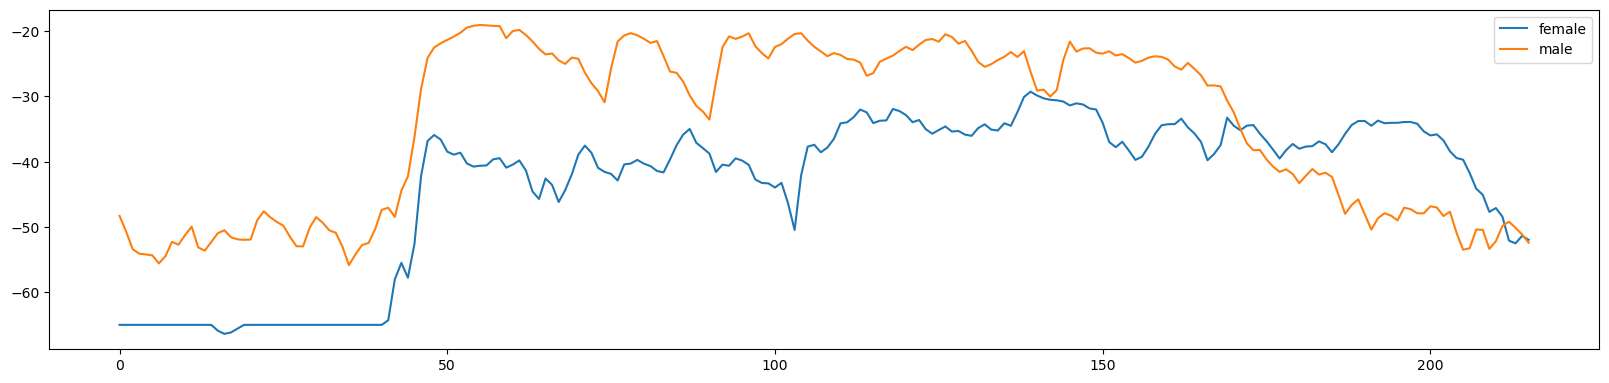

In [148]:
# Source - RAVDESS; Gender - Female; Emotion - calm 
aud_path_3 = r"RAVDESS\01-01-02-02-02-02-16.wav"
data, sample_rate = librosa.load(aud_path_3, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female_mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)
female_mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female_mfcc))


# Source - RAVDESS; Gender - Male; Emotion - calm 
aud_path_4 = r"RAVDESS\01-01-02-02-02-02-17.wav"
data, sample_rate = librosa.load(aud_path_4, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male_mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)
male_mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male_mfcc))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female_mfcc, label='female')
plt.plot(male_mfcc, label='male')
plt.legend()

#ipd.Audio(aud_path)
#ipd.Audio(aud_path_2)

# Model Training

In [114]:
# Load the extracted features
df = pd.read_csv(r"C:\Users\sandesh\Desktop\audio_analysis\audio_features_ALL.csv")

In [115]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['emotion'],axis=1)
                                                    , df.emotion
                                                    , test_size=0.20
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

feature_0   feature_1  feature_2  feature_3  feature_4  feature_5  \
6110   -308.405853  100.517487 -12.666582  52.076729 -13.282567  24.203163   
12303  -424.759369  148.763000  16.893929  55.800171 -17.652109  26.993629   
5424   -331.543091    4.261273  -0.422814  10.969253 -15.071509 -10.702129   
3076   -330.251373  149.236038  -0.049378  40.940407  -1.061898 -25.252474   
5025   -327.589508   36.680553   7.425800   9.227086 -36.796959  -1.007459   
2392  -1131.370972    0.000000   0.000000   0.000000   0.000000   0.000000   
9513   -406.527527  144.163788  -4.326705  54.989811 -15.440173  26.770115   
2484  -1131.370972    0.000000   0.000000   0.000000   0.000000   0.000000   
7709   -440.433472  135.692429  13.973776  55.416969  -7.104064  27.454100   
7515   -376.900940  115.675705  30.618479  39.177994  -2.512522  13.743785   

       feature_6  feature_7  feature_8  feature_9  ...  feature_156  \
6110  -19.867140   1.175486 -16.900692  -1.838057  ...    15.216329   
12303 -13.576476   8.599051 -12.057080   1.203394  ...    14.475957   
5424   -0.552726 -18.610155  -4.461349  -3.910008  ...    19.848167   
3076    7.277956   0.195878 -13.627435   1.801760  ...    18.037414   
5025    5.562337 -10.686341  -6.281613  -5.862512  ...    21.637577   
2392    0.000000   0.000000   0.000000   0.000000  ...     0.000000   
9513  -15.417582   5.076582 -17.523851  11.459341  ...    17.620505   
2484    0.000000   0.000000   0.000000   0.000000  ...     0.000000   
7709  -14.712399  11.397108 -10.373025   5.223041  ...    15.394401   
7515   -4.798999   3.956256 -10.040323   2.034628  ...    15.576515   

       feature_157  feature_158  feature_159  feature_160  feature_161  \
6110     18.221189    18.933368    66.749904    -0.049848    -0.023275   
12303    14.842935    15.089670    63.677789     0.001181     0.031799   
5424     21.555104    22.838454    48.849669     0.037627     0.059055   
3076     17.683625    26.057884    47.992059     0.001652    -0.025782   
5025     20.497614    21.242584    50.141777     0.013370     0.010934   
2392      0.000000     0.000000     0.000000     0.000000     0.000000   
9513     17.442034    17.915230    67.354803     0.001506    -0.011578   
2484      0.000000     0.000000     0.000000     0.000000     0.000000   
7709     15.637875    14.956431    66.118563     0.009813     0.000952   
7515     16.446108    15.928403    63.202329    -0.027712    -0.007140   

       feature_162  feature_163  feature_164  feature_165  
6110     -0.019344    -0.081209     0.013759     0.021004  
12303    -0.088098    -0.040990     0.025180     0.010659  
5424     -0.044607     0.076849     0.029692     0.027744  
3076      0.017465     0.051855    -0.004278    -0.010926  
5025      0.010484     0.049450    -0.017792    -0.001376  
2392      0.000000     0.000000     0.000000     0.000000  
9513     -0.090876     0.013868     0.004159     0.004261  
2484      0.000000     0.000000     0.000000     0.000000  
7709     -0.108578    -0.009741     0.018465     0.011852  
7515     -0.093422    -0.032400     0.022391    -0.013095  

[10 rows x 166 columns]

In [116]:
# Since the data is skewed performing data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# check dataset after the normalization
X_train[150:160]

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
6110    0.751474   0.130561  -1.317695   0.849950  -0.627300   0.948641   
12303   0.254419   1.112752   0.897389   1.004298  -1.065080   1.141867   
5424    0.652634  -1.829041  -0.400222  -0.854078  -0.806533  -1.468377   
3076    0.658152   1.122383  -0.372239   0.388316   0.597077  -2.475916   
5025    0.669523  -1.169043   0.187905  -0.926297  -2.983184  -0.797070   
2392   -2.764183  -1.915793  -0.368538  -1.308787   0.703467  -0.727308   
9513    0.332305   1.019121  -0.692755   0.970706  -0.843469   1.126389   
2484   -2.764183  -1.915793  -0.368538  -1.308787   0.703467  -0.727308   
7709    0.187461   0.846659   0.678571   0.988413  -0.008282   1.173752   
7515    0.458868   0.439155   1.925823   0.315259   0.451740   0.224381   

       feature_6  feature_7  feature_8  feature_9  ...  feature_156  \
6110   -1.102128  -0.029758  -1.205911  -0.512976  ...    -0.042984   
12303  -0.296893   0.711992  -0.388324   0.128068  ...    -0.174507   
5424    1.370209  -2.006706   0.893813  -0.949679  ...     0.779837   
3076    2.372573  -0.127639  -0.653395   0.254185  ...     0.458166   
5025    2.152966  -1.214972   0.586558  -1.361207  ...     1.097716   
2392    1.440960  -0.147211   1.646875  -0.125570  ...    -2.746084   
9513   -0.532563   0.360033  -1.311098   2.289705  ...     0.384105   
2484    1.440960  -0.147211   1.646875  -0.125570  ...    -2.746084   
7709   -0.442297   0.991569  -0.104060   0.975286  ...    -0.011351   
7515    0.826666   0.248091  -0.047901   0.303267  ...     0.021001   

       feature_157  feature_158  feature_159  feature_160  feature_161  \
6110      0.348875     0.486315     0.729219    -1.343151    -0.597613   
12303    -0.229911    -0.174817     0.574554     0.089721     0.793806   
5424      0.920065     1.158006    -0.171961     1.113124     1.482424   
3076      0.256776     1.711761    -0.215137     0.102950    -0.660939   
5025      0.738889     0.883510    -0.106911     0.432009     0.266669   
2392     -2.772908    -2.770302    -2.631278     0.056571    -0.009575   
9513      0.215385     0.311191     0.759672     0.098856    -0.302096   
2484     -2.772908    -2.770302    -2.631278     0.056571    -0.009575   
7709     -0.093716    -0.197734     0.697434     0.332126     0.014467   
7515      0.044756    -0.030551     0.550618    -0.721567    -0.189953   

       feature_162  feature_163  feature_164  feature_165  
6110      0.305870    -0.768747     0.129650     0.737375  
12303    -0.623116    -0.182815     0.648665     0.269859  
5424     -0.035479     1.533913     0.853713     1.041975  
3076      0.803220     1.169790    -0.690111    -0.705610  
5025      0.708900     1.134746    -1.304241    -0.274010  
2392      0.567238     0.414341    -0.495672    -0.211842  
9513     -0.660654     0.616381    -0.306665    -0.019274  
2484      0.567238     0.414341    -0.495672    -0.211842  
7709     -0.899837     0.272433     0.343487     0.323781  
7515     -0.695059    -0.057671     0.521940    -0.803654  

[10 rows x 166 columns]

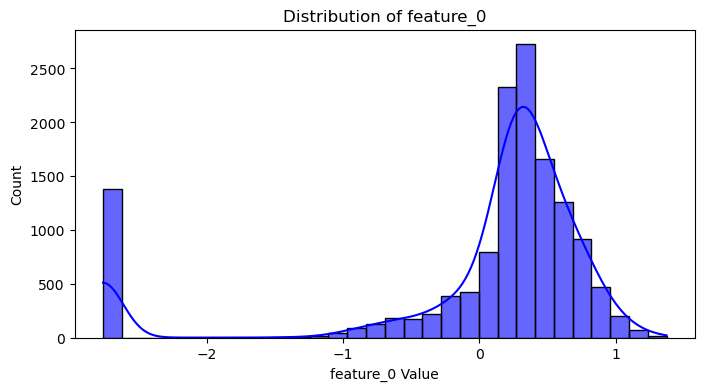

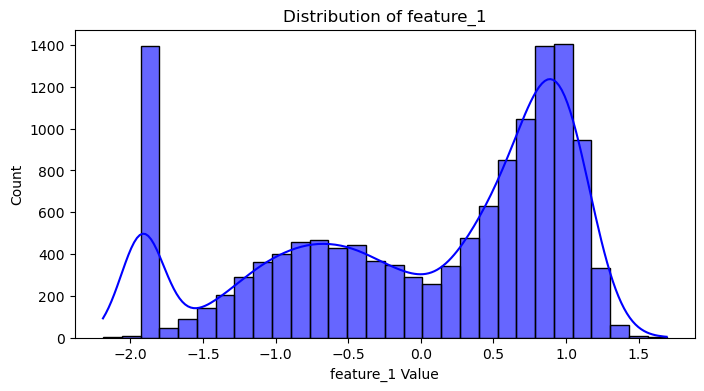

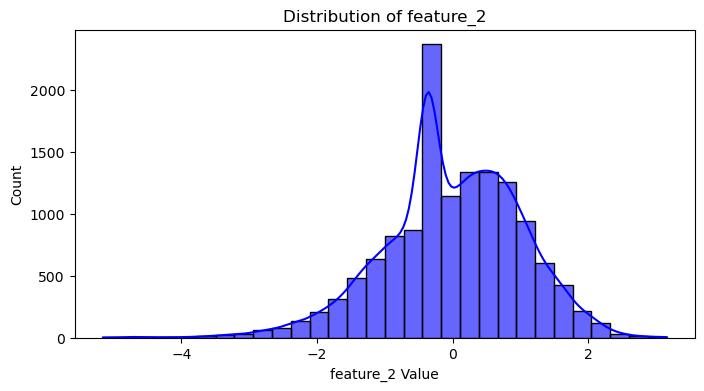

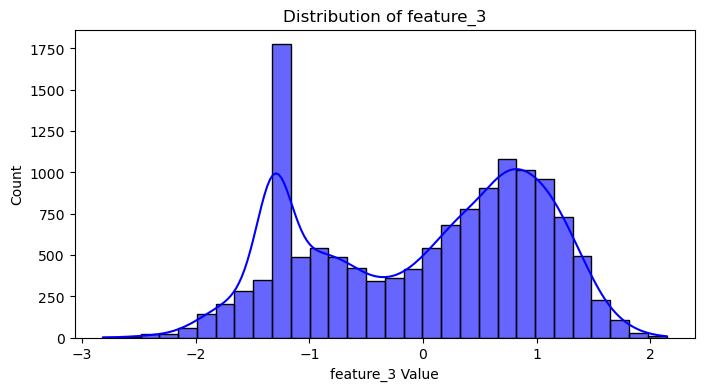

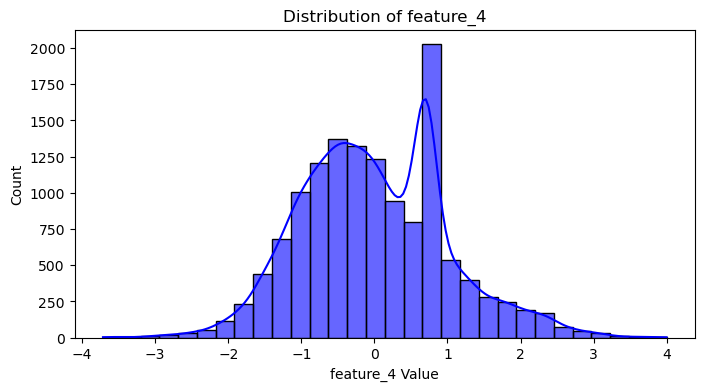

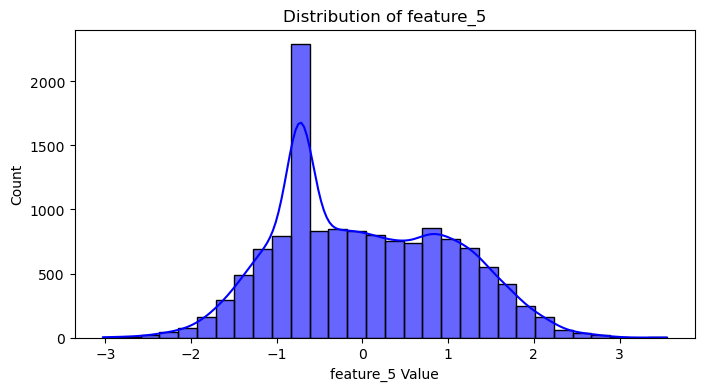

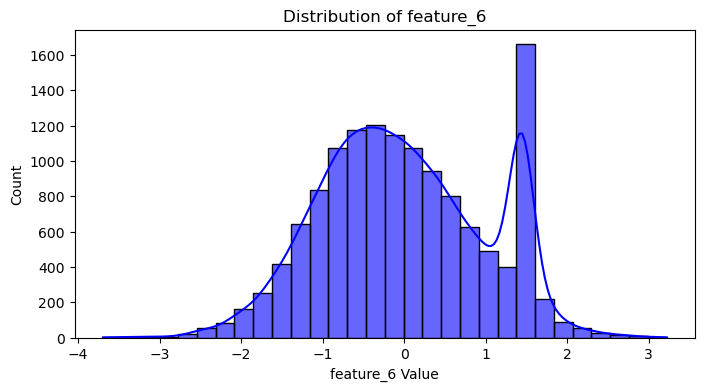

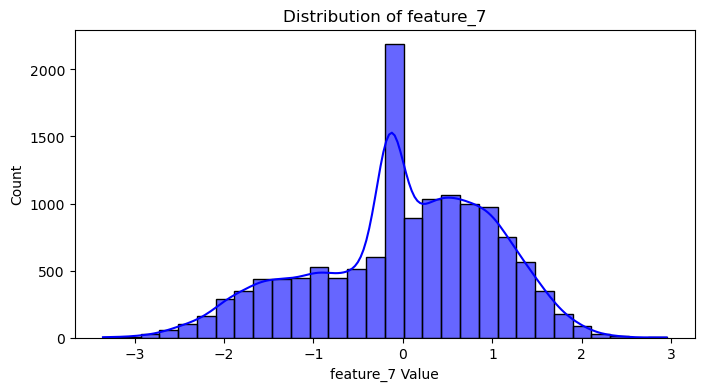

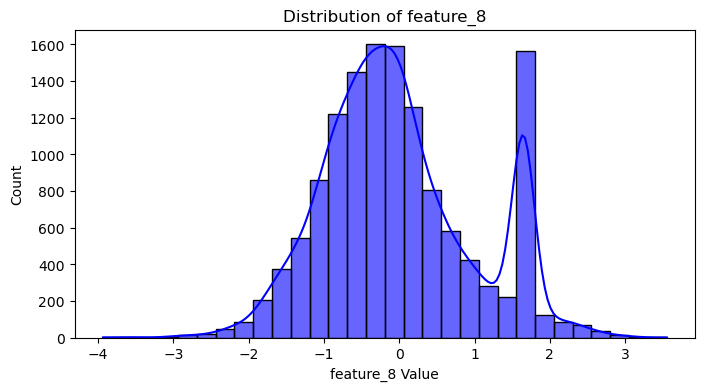

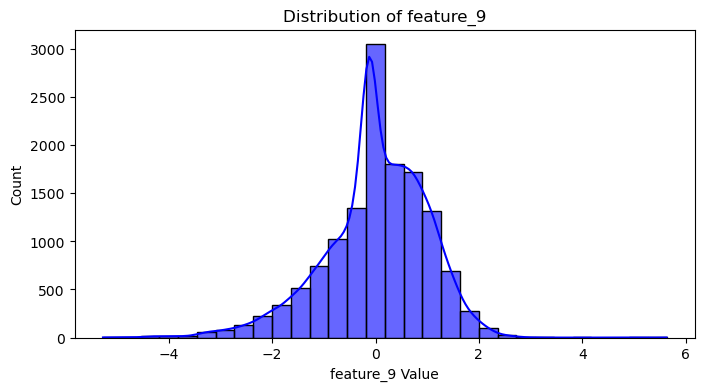

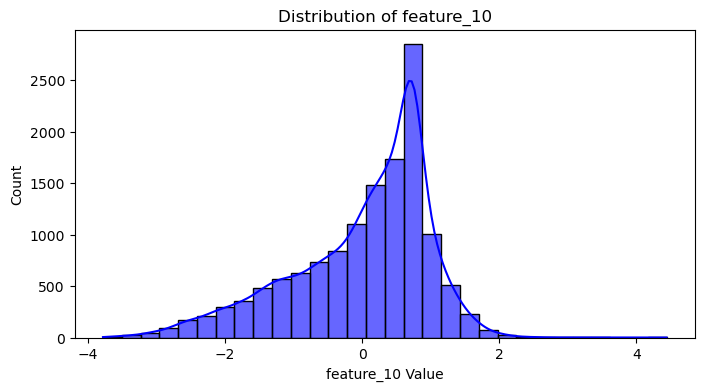

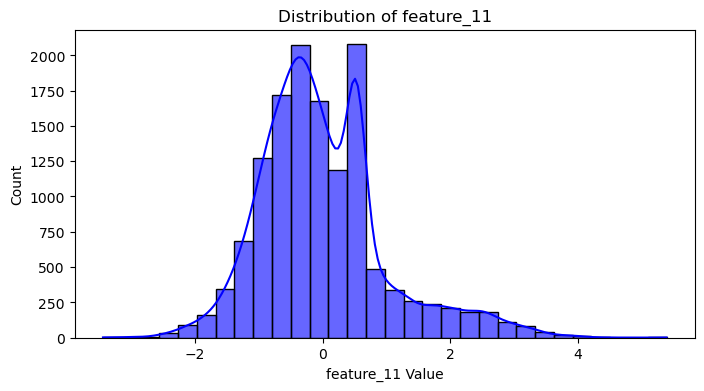

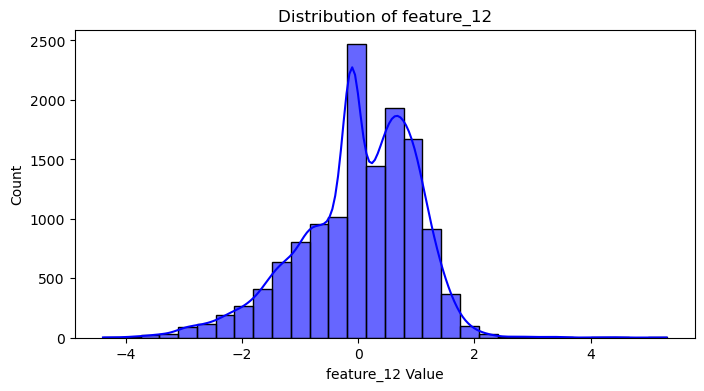

In [71]:
# MFCC feature distribution (first 13 feature will be related to MFCC)- After Normalization
x_concatenated = pd.concat([X_train,X_test], axis=0, ignore_index=True)
for i in range(13):
    plt.figure(figsize=(8, 4))
    sns.histplot(x_concatenated[f'feature_{i}'], kde=True, bins=30, alpha=0.6, color='blue')
    plt.title(f'Distribution of feature_{i}')
    plt.xlabel(f'feature_{i} Value')
    plt.ylabel('Count')
    plt.show()

In [117]:
# converting to np array
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

(10785, 166)
['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [73]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(10785, 166, 1)

In [107]:
# New model
emo_model = Sequential()
emo_model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
emo_model.add(Activation('relu'))
emo_model.add(Conv1D(256, 8, padding='same'))
emo_model.add(BatchNormalization())
emo_model.add(Activation('relu'))
emo_model.add(Dropout(0.25))
emo_model.add(MaxPooling1D(pool_size=(8)))
emo_model.add(Conv1D(128, 8, padding='same'))
emo_model.add(Activation('relu'))
emo_model.add(Conv1D(128, 8, padding='same'))
emo_model.add(Activation('relu'))
emo_model.add(Conv1D(128, 8, padding='same'))
emo_model.add(Activation('relu'))
emo_model.add(Conv1D(128, 8, padding='same'))
emo_model.add(BatchNormalization())
emo_model.add(Activation('relu'))
emo_model.add(Dropout(0.25))
emo_model.add(MaxPooling1D(pool_size=(8)))
emo_model.add(Conv1D(64, 8, padding='same'))
emo_model.add(Activation('relu'))
emo_model.add(Conv1D(64, 8, padding='same'))
emo_model.add(Activation('relu'))
emo_model.add(Flatten())
emo_model.add(Dense(8)) # Target class number
emo_model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = tf.keras.optimizers.legacy.RMSprop(lr=0.00001, decay=1e-6)
emo_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 166, 256)          2304      
                                                                 
 activation_18 (Activation)  (None, 166, 256)          0         
                                                                 
 conv1d_17 (Conv1D)          (None, 166, 256)          524544    
                                                                 
 batch_normalization_4 (Bat  (None, 166, 256)          1024      
 chNormalization)                                                
                                                                 
 activation_19 (Activation)  (None, 166, 256)          0         
                                                                 
 dropout_4 (Dropout)         (None, 166, 256)          0         
                                                      

In [ ]:
emo_model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_hist=emo_model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

In [109]:
# Evaluate the model
test_loss, test_accuracy = emo_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

106/106 [==============================] - 5s 51ms/step - loss: 1.1713 - accuracy: 0.5429
Test accuracy: 0.5428656339645386


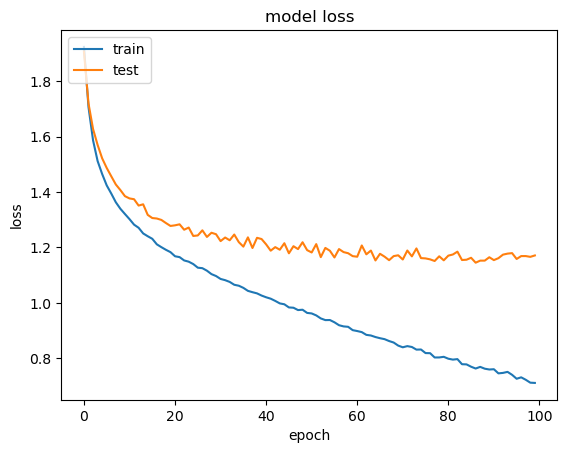

In [110]:
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right)
plt.show()

In [ ]:
# Save model and weights
saved_model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
saved_model_path = os.path.join(save_dir, saved_model_name)
emo_model.save(saved_model_path)

# Save the model to disk
saved_model_json = emo_model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(saved_model_json)

In [162]:
# `X_test` is your test set features and `model` is trained model
y_pred = emo_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)
y_pred = y_pred.argmax(axis=1)
y_pred

211/211 [==============================] - 6s 29ms/step


array([3, 0, 1, ..., 5, 1, 3], dtype=int64)

In [163]:
# predictions 
y_pred = y_pred.astype(int).flatten()
y_pred = (lb.inverse_transform((y_pred)))
y_pred = pd.DataFrame({'predictedvalues': y_pred})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(y_pred)
finaldf[170:180]

actualvalues predictedvalues
170      neutral         neutral
171      neutral             sad
172      disgust         disgust
173      neutral         neutral
174         fear            fear
175        angry            calm
176         fear            fear
177      neutral         neutral
178      disgust        surprise
179        angry           angry

In [199]:
accuracy = accuracy_score(actual, y_pred)
print(f"Accuracy: {accuracy}")

# Generate a classification report
report = classification_report(actual, y_pred)

con_matrix = confusion_matrix(actual, y_pred)
print(report)

Accuracy: 0.5428656185108276
              precision    recall  f1-score   support

       angry       0.69      0.63      0.66       507
        calm       0.20      0.92      0.33        99
     disgust       0.59      0.38      0.46       516
        fear       0.46      0.59      0.51       497
       happy       0.61      0.42      0.50       524
     neutral       0.60      0.53      0.56       481
         sad       0.62      0.60      0.61       543
    surprise       0.75      0.67      0.70       204

    accuracy                           0.54      3371
   macro avg       0.56      0.59      0.54      3371
weighted avg       0.59      0.54      0.55      3371



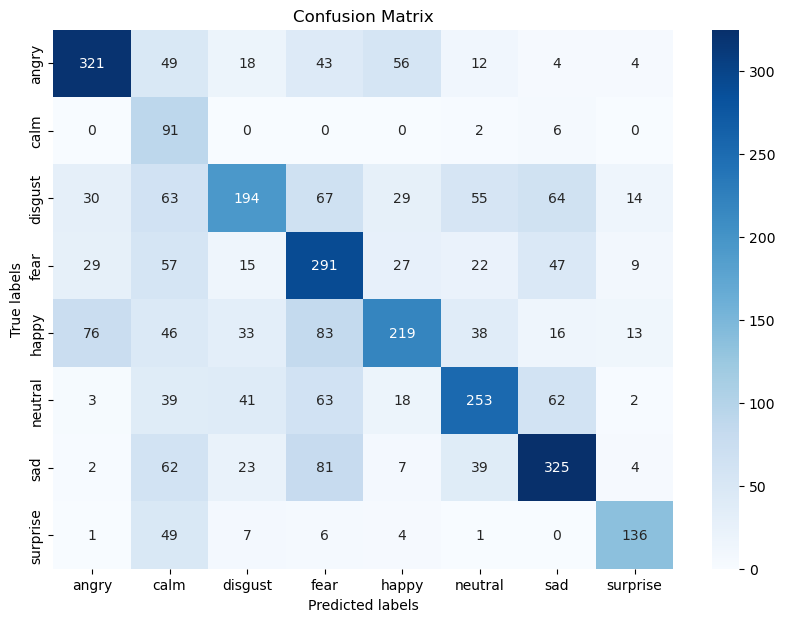

In [171]:
# Plotting with Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(con_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title('Confusion Matrix')
plt.show()


### CUSTOM DATA VALIDATION

In [198]:
# Load the extracted features
df_raw = pd.read_csv(r"C:\Users\sandesh\Desktop\audio_analysis\audio_features_CUSTOM.csv")
df_raw

feature_0   feature_1  feature_2  feature_3  feature_4  feature_5  \
0 -448.836426  100.451759 -19.195988  17.637526   9.127409   0.259150   
1 -394.157440  104.939705 -24.048580  14.412387   2.854964  -1.339242   
2 -494.028259   65.522369  22.347092  17.417589  16.986153   6.114890   
3 -247.034424   94.172928 -29.879520  28.388540 -14.999281  16.467449   
4 -432.173737   95.245857  19.664179  33.064739   0.454268  16.138260   
5 -467.676147   89.747055  -6.395028  22.911013  10.650039   1.583437   

   feature_6  feature_7  feature_8  feature_9  ...  feature_157  feature_158  \
0  -8.570551 -13.403028  -6.109199   6.499374  ...    19.344065    21.523863   
1  -9.137506 -11.138186  -5.262276   2.098566  ...    18.358630    20.234490   
2 -19.187027  17.712360   5.924967  17.767094  ...    18.232113    17.342464   
3  -5.390965   6.013389 -10.522986   3.616946  ...    16.736101    17.279513   
4  -1.910012   9.827790  -2.668010   3.735887  ...    14.374006    14.506446   
5   1.018756  -8.933990  -8.795280   3.058832  ...    17.216376    20.592796   

   feature_159  feature_160  feature_161  feature_162  feature_163  \
0    45.758942    -0.009863     0.074906     0.008373     0.012587   
1    45.998944     0.003597     0.038250     0.066313    -0.010174   
2    48.819900     0.005701     0.029816     0.073018     0.048081   
3    51.134885     0.043417    -0.021254    -0.014354    -0.045335   
4    51.048005     0.025055    -0.002453     0.089429    -0.005401   
5    46.020835    -0.042550     0.021958     0.066799    -0.014825   

   feature_164  feature_165   emotion  
0    -0.009413    -0.015452     angry  
1    -0.020192     0.003554      calm  
2    -0.002366     0.001398      calm  
3    -0.007101     0.013526       sad  
4    -0.020926    -0.006665       sad  
5    -0.011514     0.009952  surprise  

[6 rows x 167 columns]

In [199]:
X_test_raw = df_raw.drop(['emotion'],axis=1)
y_test_raw = np.array(df_raw.emotion)
print(y_test_raw)

['angry' 'calm' 'calm' 'sad' 'sad' 'surprise']


In [200]:
X_test_raw = (X_test_raw - mean)/std

In [201]:
X_test_raw = np.array(X_test_raw)
y_test_raw = np.array(y_test_raw)

#y_test_raw = np.argmax(y_one_hot_raw,axis=1)

y_test_raw = to_categorical(lb.fit_transform(y_test_raw))
X_test_raw = np.expand_dims(X_test_raw, axis=2)
print(y_test_raw)
print(lb.classes_)
#print(lb_raw.classes_)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
['angry' 'calm' 'sad' 'surprise']


In [202]:
# loading json and model architecture 
saved_json_file = open('model_json.json', 'r')
load_saved_model_json = saved_json_file.read()
saved_json_file.close()
load_saved_model = model_from_json(load_saved_model_json)

# load weights into new model
load_saved_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
#from tensorflow.keras.models import load_model
#load_saved_model = load_model('saved_models/Emotion_Model.h5')

Loaded model from disk


In [203]:
y_pred_raw = load_saved_model.predict(X_test_raw,batch_size=16, 
                         verbose=1)

y_pred_raw = y_pred_raw.argmax(axis=1)
y_pred_raw

1/1 [==============================] - 0s 222ms/step


array([6, 0, 6, 3, 1, 7], dtype=int64)

In [204]:
# predictions 
y_pred_raw = y_pred_raw.astype(int).flatten()
y_pred_raw = (lb_raw.inverse_transform((y_pred_raw)))
y_pred_raw = pd.DataFrame({'predictedvalues': y_pred_raw})

# Actual labels
actual_raw=y_test_raw.argmax(axis=1)
actual_raw = actual_raw.astype(int).flatten()
actual_raw = (lb.inverse_transform((actual_raw)))
actual_raw = pd.DataFrame({'actualvalues': actual_raw})

# Lets combined both of them into a single dataframe
finaldf_raw = actual_raw.join(y_pred_raw)
finaldf_raw

actualvalues predictedvalues
0        angry             sad
1         calm           angry
2         calm             sad
3          sad            fear
4          sad            calm
5     surprise        surprise

In [205]:
accuracy_raw = accuracy_score(actual_raw, y_pred_raw)
print(f"Accuracy: {accuracy_raw}")

# Generate a classification report
report_raw = classification_report(actual_raw, y_pred_raw)

con_matrix_raw = confusion_matrix(actual_raw, y_pred_raw)
print(report_raw)

Accuracy: 0.16666666666666666
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00         1
        calm       0.00      0.00      0.00         2
        fear       0.00      0.00      0.00         0
         sad       0.00      0.00      0.00         2
    surprise       1.00      1.00      1.00         1

    accuracy                           0.17         6
   macro avg       0.20      0.20      0.20         6
weighted avg       0.17      0.17      0.17         6

